In [1]:
import os
import numpy as np
import pandas as pd
from math import ceil
import winshell

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, jaccard_score, accuracy_score, classification_report, confusion_matrix

In [2]:
base_path = winshell.shortcut(r"G:/My Drive/Thesis/HAM10000.lnk").path

for item in os.listdir(base_path):
    print(item)

HAM10000_metadata.csv
hmnist_28_28_L.csv
hmnist_28_28_RGB.csv
hmnist_8_8_L.csv
hmnist_8_8_RGB.csv
HAM10000_images_part_2
HAM10000_images_part_1


In [3]:
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
Built with CUDA: True
Num GPUs Available:  1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
image_dir_1 = os.path.join(base_path, "HAM10000_images_part_1")
image_dir_2 = os.path.join(base_path, "HAM10000_images_part_2")

images = os.listdir(image_dir_1) + os.listdir(image_dir_2)
print(f"Total images: {len(images)}")

Total images: 10015


In [5]:
df = pd.read_csv(base_path + "\HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
df_train, df_temp = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['dx'], random_state=42)

print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")   
print(f"Test set size: {len(df_test)}")

Training set size: 8012
Validation set size: 1001
Test set size: 1002


In [7]:
df_train['path'] = df_train['image_id'].apply(
    lambda x: os.path.join(image_dir_1, f"{x}.jpg")
    if os.path.exists(os.path.join(image_dir_1, f"{x}.jpg"))
    else os.path.join(image_dir_2, f"{x}.jpg")
)

df_val['path'] = df_val['image_id'].apply(
    lambda x: os.path.join(image_dir_1, f"{x}.jpg")
    if os.path.exists(os.path.join(image_dir_1, f"{x}.jpg"))
    else os.path.join(image_dir_2, f"{x}.jpg")
)

df_test['path'] = df_test['image_id'].apply(
    lambda x: os.path.join(image_dir_1, f"{x}.jpg")
    if os.path.exists(os.path.join(image_dir_1, f"{x}.jpg"))
    else os.path.join(image_dir_2, f"{x}.jpg")
)

In [8]:
nan_count = df_train.isnull().sum()
nan_count

lesion_id        0
image_id         0
dx               0
dx_type          0
age             44
sex              0
localization     0
path             0
dtype: int64

In [9]:
df_train = df_train.dropna()
df_val = df_val.dropna()
df_test = df_test.dropna()

dx distribution in the training set:
 dx
nv       5331
mel       889
bkl       869
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64


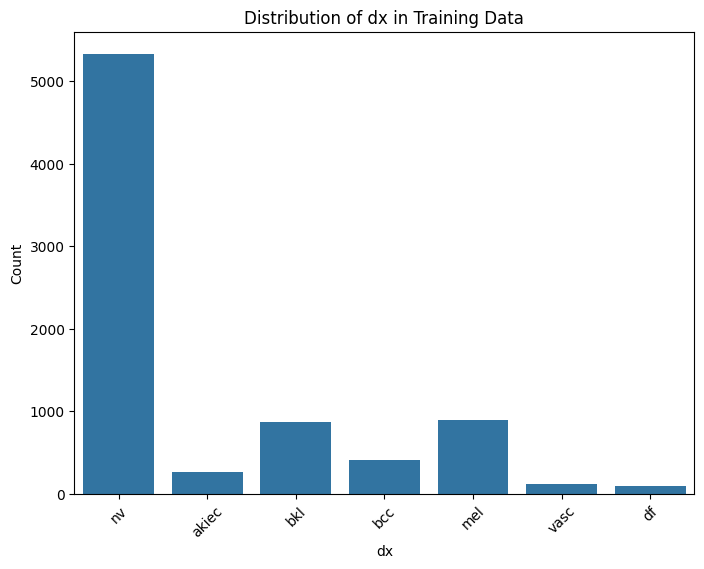

In [10]:
dx_counts = df_train['dx'].value_counts()
print("dx distribution in the training set:\n", dx_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='dx', data=df_train)
plt.title('Distribution of dx in Training Data')
plt.xlabel('dx')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [11]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
RANDOM_STATE = 42

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='path',
    y_col='dx',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_STATE
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='path',
    y_col='dx',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='path',
    y_col='dx',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 7968 validated image filenames belonging to 7 classes.
Found 995 validated image filenames belonging to 7 classes.
Found 995 validated image filenames belonging to 7 classes.


In [12]:
base_model = Xception(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(7, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = True

optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [13]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
249/249 [==============================] - 184s 707ms/step - loss: 0.8904 - accuracy: 0.7016 - val_loss: 0.6304 - val_accuracy: 0.7668 - lr: 1.0000e-04
Epoch 2/50
249/249 [==============================] - 174s 697ms/step - loss: 0.5721 - accuracy: 0.7987 - val_loss: 0.5617 - val_accuracy: 0.8020 - lr: 1.0000e-04
Epoch 3/50
249/249 [==============================] - 173s 693ms/step - loss: 0.4545 - accuracy: 0.8335 - val_loss: 0.5423 - val_accuracy: 0.8050 - lr: 1.0000e-04
Epoch 4/50
249/249 [==============================] - 171s 685ms/step - loss: 0.3879 - accuracy: 0.8576 - val_loss: 0.5066 - val_accuracy: 0.8312 - lr: 1.0000e-04
Epoch 5/50
249/249 [==============================] - 173s 694ms/step - loss: 0.3244 - accuracy: 0.8809 - val_loss: 0.5710 - val_accuracy: 0.8131 - lr: 1.0000e-04
Epoch 6/50
249/249 [==============================] - 171s 687ms/step - loss: 0.2803 - accuracy: 0.9009 - val_loss: 0.5262 - val_accuracy: 0.8281 - lr: 1.0000e-04
Epoch 7/50
249/249 [==

In [14]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

unique_classes = np.unique(y_true)
iou_scores = [jaccard_score(y_true == cls, y_pred_classes == cls) for cls in unique_classes]
f1_scores = [f1_score(y_true == cls, y_pred_classes == cls) for cls in unique_classes]

test_acc = accuracy_score(y_true, y_pred_classes)
mean_iou = np.mean(iou_scores)
std_iou = np.std(iou_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print("Mean IoU:", mean_iou)
print("Std IoU:", std_iou)
print("Mean F1:", mean_f1)
print("Std F1:", std_f1)
print("Eval. Score:", test_acc)

32/32 [==============================] - 17s 527ms/step
Mean IoU: 0.5741688837653518
Std IoU: 0.155408989449683
Mean F1: 0.7174658881480173
Std F1: 0.12245695114407006
Eval. Score: 0.8402010050251256


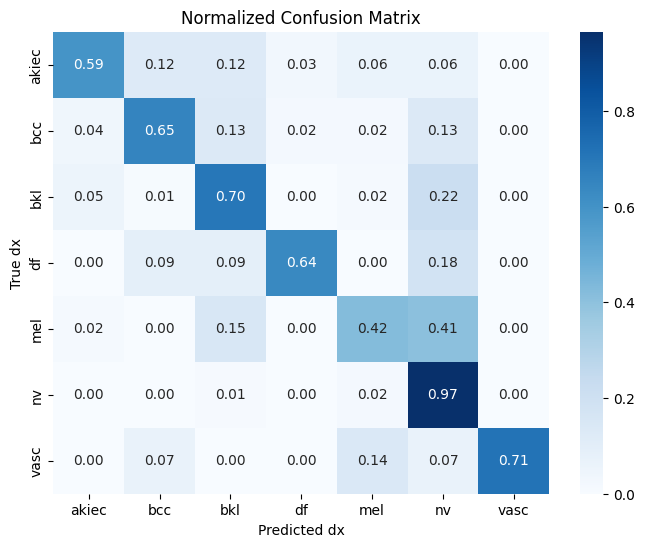

In [15]:
cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_labels = list(test_gen.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted dx")
plt.ylabel("True dx")
plt.title("Normalized Confusion Matrix")
plt.show()